In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [22]:
# Config variables
# Data images are not of the same size
INPUT_SIZE = [224, 224]
BATCH = 32

In [23]:
# No data augmentation
train_val_image_data_generator = ImageDataGenerator(rescale=1.0/255,
                                            rotation_range=20,
                                            zoom_range=0.2,
                                            width_shift_range=0.2,
                                            height_shift_range=0.2,
                                            shear_range=0.2,
                                            horizontal_flip=True,
                                            fill_mode="nearest",
                                            validation_split=0.2
                                            )

train_data = train_val_image_data_generator.flow_from_directory('./data/',
                                                     target_size = INPUT_SIZE,
                                                     batch_size=BATCH,
                                                     class_mode = 'binary',
                                                     subset='training',
                                                     shuffle=True
                                                     )
validate_data = train_val_image_data_generator.flow_from_directory('./data/',
                                                     target_size = INPUT_SIZE,
                                                     batch_size=BATCH,
                                                     class_mode = 'binary',
                                                     subset='validation',
                                                     shuffle=True
                                                     )

Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


In [24]:
inceptionv3_m_pre = tf.keras.applications.InceptionV3(input_shape = (224, 224, 3),
    include_top=False, weights=None
)
inceptionv3_m_pre.summary()



Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [ ]:
for layer in inceptionv3_m_pre.layers:
  layer.trainable = False

last_layer = inceptionv3_m_pre.get_layer('mixed10')
last_output = last_layer.output

from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (1, activation='sigmoid')(x)           

inceptionv3_m = Model( inceptionv3_m_pre.input, x) 

In [ ]:

inceptionv3_m.compile(
  loss='binary_crossentropy',
  optimizer='SGD',
  metrics=['accuracy']
)

In [ ]:
es = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='auto')

inceptionv3_m_r = inceptionv3_m.fit(
  train_data,
  validation_data=validate_data,
  epochs=25,
  steps_per_epoch=len(train_data),
  validation_steps=len(validate_data),
  callbacks=[es]
)

Epoch 1/25
 90/189 [=============>................] - ETA: 1:51 - loss: 0.1963 - accuracy: 0.9343

KeyboardInterrupt: 

In [ ]:
inceptionv3_m.save('./inceptionv3_m/inceptionv3_m.h5')

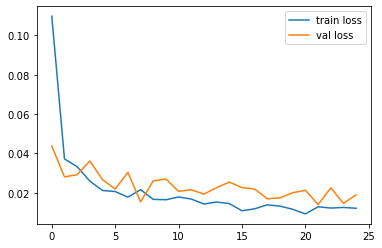

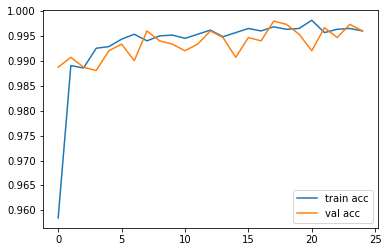

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(inceptionv3_m_r.history['loss'], label='train loss')
plt.plot(inceptionv3_m_r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('./inceptionv3_m/inceptionv3_m_LossVal_loss.png')

# plot the accuracy
plt.plot(inceptionv3_m_r.history['accuracy'], label='train acc')
plt.plot(inceptionv3_m_r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('./inceptionv3_m/inceptionv3_m_AccVal_acc.png')

In [ ]:
test_image = image.load_img('./data/without_mask/without_mask_3810.jpg', target_size = INPUT_SIZE)
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = inceptionv3_m.predict(test_image)
if result[0][0] < 0.5:
    print('Image classified as With mask')
else:
    print('Image classified as Without mask')

Image classified as Without mask
